## Import stuff

In [6]:
import sys
sys.path.append('/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/pydelfi')

import numpy as np
import matplotlib.pyplot as plt
import priors as priors
import ndes as ndes
import delfi as delfi
import tensorflow as tf

## Set up the prior

In [7]:
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior = priors.Uniform(lower, upper)

## Load in the compressed data vector, sims, Fisher matrix, fiducial params
`compressed_data` is an array of length `n_summaries`<br>
`sim_params` is an array with shape `(n_simulations, n_parameters)`<br>
`sim_compressed_data` is an array with shape `(n_simulations, n_summaries)`

In [8]:
compressed_data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/compressed_data.dat')

sim_params = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_parameters.dat')

sim_compressed_data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_compressed_data.dat')

Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

## Create ensemble of NDEs

In [9]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hidden=[50,50], n_mades=5, activations=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh]),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh])]       

## Create DELFI object

In [11]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                            results_dir = "simulators/cosmic_shear/results_prerun/",
                            input_normalization="fisher")

## Load simulations into DELFI object

In [12]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

## Fisher pre-training to initialize networks

In [13]:
DelfiEnsemble.fisher_pretraining(n_batch=5000, batch_size=100)

KeyboardInterrupt: 

# Train the networks

In [8]:
DelfiEnsemble.train_ndes()

# Sample the learned posterior

In [9]:
posterior_samples, posterior_weights, log_posterior_values = DelfiEnsemble.emcee_sample()

# Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


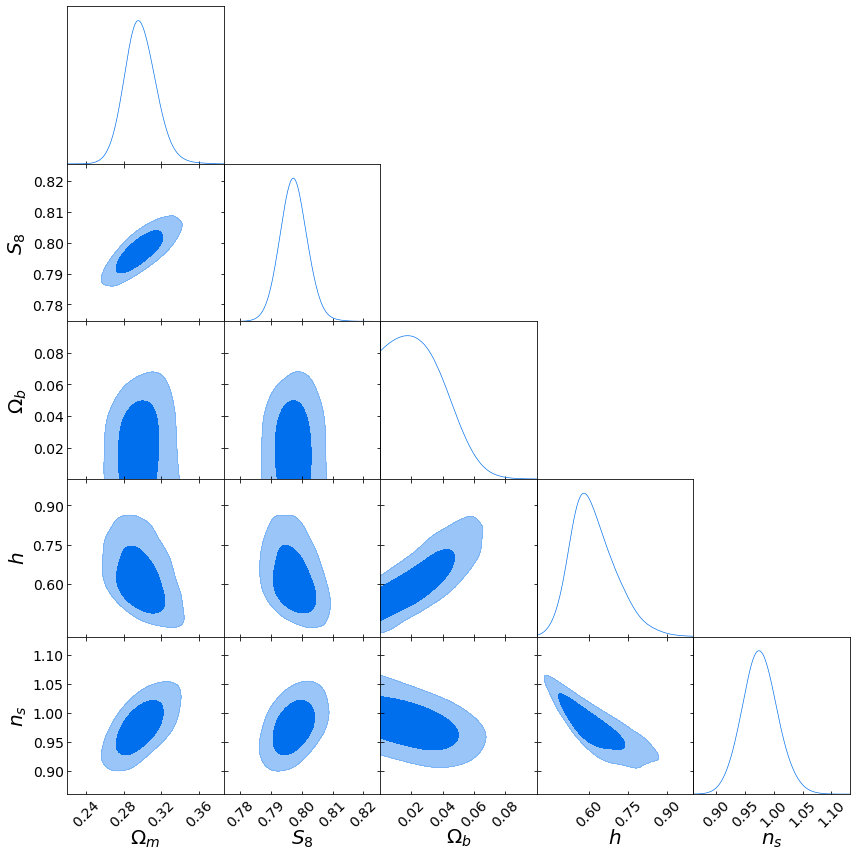

In [10]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])